In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import ip2geotools
from ip2geotools.databases.noncommercial import DbIpCity

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [36]:
# Load the data from the .json file into a dataframe
df = pd.read_json ("customers.json", lines = True)
pd.set_option('max_colwidth', -1)

df.head(15)

,fraudulent,customer,orders,paymentMethods,transactions
0,False,"{'customerEmail': 'josephhoward@yahoo.com', 'customerPhone': '400-108-5415', 'customerDevice': 'yyeiaxpltf82440jnb3v', 'customerIPAddress': '8.129.104.40', 'customerBillingAddress': '5493 Jones Islands Brownside, CA 51896'}","[{'orderId': 'vjbdvd', 'orderAmount': 18, 'orderState': 'pending', 'orderShippingAddress': '5493 Jones Islands Brownside, CA 51896'}, {'orderId': 'yp6x27', 'orderAmount': 26, 'orderState': 'fulfilled', 'orderShippingAddress': '5493 Jones Islands Brownside, CA 51896'}]","[{'paymentMethodId': 'wt07xm68b', 'paymentMethodRegistrationFailure': True, 'paymentMethodType': 'card', 'paymentMethodProvider': 'JCB 16 digit', 'paymentMethodIssuer': 'Citizens First Banks'}]","[{'transactionId': 'a9lcj51r', 'orderId': 'vjbdvd', 'paymentMethodId': 'wt07xm68b', 'transactionAmount': 18, 'transactionFailed': False}, {'transactionId': 'y4wcv03i', 'orderId': 'yp6x27', 'paymentMethodId': 'wt07xm68b', 'transactionAmount': 26, 'transactionFailed': False}]"
1,True,"{'customerEmail': 'evansjeffery@yahoo.com', 'customerPhone': '1-788-091-7546', 'customerDevice': 'r0jpm7xaeqqa3kr6mzum', 'customerIPAddress': '219.173.211.202', 'customerBillingAddress': '356 Elizabeth Inlet Suite 120 Port Joshuabury, NM 37681'}","[{'orderId': 'nlghpa', 'orderAmount': 45, 'orderState': 'fulfilled', 'orderShippingAddress': '898 Henry Ports New Keithview, CA 95893-2497'}, {'orderId': 'uw0eeb', 'orderAmount': 23, 'orderState': 'fulfilled', 'orderShippingAddress': '356 Elizabeth Inlet Suite 120 Port Joshuabury, NM 37681'}, {'orderId': 'bn44oh', 'orderAmount': 43, 'orderState': 'fulfilled', 'orderShippingAddress': '5093 Bryan Forks Joshuaton, FM 01565-9801'}]","[{'paymentMethodId': 'y3xp697jx', 'paymentMethodRegistrationFailure': True, 'paymentMethodType': 'bitcoin', 'paymentMethodProvider': 'VISA 16 digit', 'paymentMethodIssuer': 'Solace Banks'}, {'paymentMethodId': '6krszxc05', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'VISA 16 digit', 'paymentMethodIssuer': 'Vertex Bancorp'}, {'paymentMethodId': '5z1szj2he', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'Diners Club / Carte Blanche', 'paymentMethodIssuer': 'His Majesty Bank Corp.'}, {'paymentMethodId': 'm52tx8e1s', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'Mastercard', 'paymentMethodIssuer': 'Vertex Bancorp'}, {'paymentMethodId': '41ug157xz', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'bitcoin', 'paymentMethodProvider': 'American Express', 'paymentMethodIssuer': 'Bastion Banks'}, {'paymentMethodId': '4dpg5sx2b', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'Maestro', 'paymentMethodIssuer': 'Her Majesty Trust'}, {'paymentMethodId': 'bcx9pa3wf', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'JCB 16 digit', 'paymentMethodIssuer': 'Fountain Financial Inc.'}]","[{'transactionId': '5mi94sfw', 'orderId': 'nlghpa', 'paymentMethodId': '41ug157xz', 'transactionAmount': 45, 'transactionFailed': False}, {'transactionId': 'br8ba1nu', 'orderId': 'uw0eeb', 'paymentMethodId': '41ug157xz', 'transactionAmount': 23, 'transactionFailed': False}, {'transactionId': 'a33145ss', 'orderId': 'bn44oh', 'paymentMethodId': 'y3xp697jx', 'transactionAmount': 43, 'transactionFailed': True}]"
2,False,"{'customerEmail': 'andersonwilliam@yahoo.com', 'customerPhone': '024.420.0375', 'customerDevice': '4m7h5ipl1shyavt6vv2r', 'customerIPAddress': '67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0', 'customerBillingAddress': '8478 Sean Ridges Apt. 441 Davisberg, PR 72250'}","[{'orderId': 'yk34y2', 'orderAmount': 33, 'orderState': 'failed', 'orderShippingAddress': '8478 Sean Ridges Apt. 441 Davisberg, PR 72250'}, {'orderId': '28v6b0', 'orderAmount': 24, 'orderState': 'fulfilled', 'orderShippingAddress': '8478

In [37]:
# Count how many fraudulent and non-fraudulent transactions there are (including the items with missing values)
df['fraudulent'].value_counts(dropna=False)
# The data is relatively balanced

False    107
True     61 
Name: fraudulent, dtype: int64

In [38]:
# Let's look at the fraudulent transactions
df[df.fraudulent == True]
# They seem to have:
# multiple orders, sometimes to the address that doesn't match the billing address;
# different payment methods,
# failed transactions,
# sometimes there's data on payment methods but not on transactions.

,fraudulent,customer,orders,paymentMethods,transactions
1,True,"{'customerEmail': 'evansjeffery@yahoo.com', 'customerPhone': '1-788-091-7546', 'customerDevice': 'r0jpm7xaeqqa3kr6mzum', 'customerIPAddress': '219.173.211.202', 'customerBillingAddress': '356 Elizabeth Inlet Suite 120 Port Joshuabury, NM 37681'}","[{'orderId': 'nlghpa', 'orderAmount': 45, 'orderState': 'fulfilled', 'orderShippingAddress': '898 Henry Ports New Keithview, CA 95893-2497'}, {'orderId': 'uw0eeb', 'orderAmount': 23, 'orderState': 'fulfilled', 'orderShippingAddress': '356 Elizabeth Inlet Suite 120 Port Joshuabury, NM 37681'}, {'orderId': 'bn44oh', 'orderAmount': 43, 'orderState': 'fulfilled', 'orderShippingAddress': '5093 Bryan Forks Joshuaton, FM 01565-9801'}]","[{'paymentMethodId': 'y3xp697jx', 'paymentMethodRegistrationFailure': True, 'paymentMethodType': 'bitcoin', 'paymentMethodProvider': 'VISA 16 digit', 'paymentMethodIssuer': 'Solace Banks'}, {'paymentMethodId': '6krszxc05', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'VISA 16 digit', 'paymentMethodIssuer': 'Vertex Bancorp'}, {'paymentMethodId': '5z1szj2he', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'Diners Club / Carte Blanche', 'paymentMethodIssuer': 'His Majesty Bank Corp.'}, {'paymentMethodId': 'm52tx8e1s', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'Mastercard', 'paymentMethodIssuer': 'Vertex Bancorp'}, {'paymentMethodId': '41ug157xz', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'bitcoin', 'paymentMethodProvider': 'American Express', 'paymentMethodIssuer': 'Bastion Banks'}, {'paymentMethodId': '4dpg5sx2b', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'Maestro', 'paymentMethodIssuer': 'Her Majesty Trust'}, {'paymentMethodId': 'bcx9pa3wf', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'JCB 16 digit', 'paymentMethodIssuer': 'Fountain Financial Inc.'}]","[{'transactionId': '5mi94sfw', 'orderId': 'nlghpa', 'paymentMethodId': '41ug157xz', 'transactionAmount': 45, 'transactionFailed': False}, {'transactionId': 'br8ba1nu', 'orderId': 'uw0eeb', 'paymentMethodId': '41ug157xz', 'transactionAmount': 23, 'transactionFailed': False}, {'transactionId': 'a33145ss', 'orderId': 'bn44oh', 'paymentMethodId': 'y3xp697jx', 'transactionAmount': 43, 'transactionFailed': True}]"
4,True,"{'customerEmail': 'uchen@malone.com', 'customerPhone': '1-981-877-0870', 'customerDevice': 'j0pd24k5h8dl2fqu0cz4', 'customerIPAddress': '196.89.235.192', 'customerBillingAddress': '148 Russell Lodge Apt. 445 Port Jenniferside, TN 60556-0871'}","[{'orderId': '56h7iw', 'orderAmount': 71, 'orderState': 'fulfilled', 'orderShippingAddress': '148 Russell Lodge Apt. 445 Port Jenniferside, TN 60556-0871'}, {'orderId': 'kowj1v', 'orderAmount': 66, 'orderState': 'fulfilled', 'orderShippingAddress': '148 Russell Lodge Apt. 445 Port Jenniferside, TN 60556-0871'}, {'orderId': 'wlznfu', 'orderAmount': 69, 'orderState': 'failed', 'orderShippingAddress': '148 Russell Lodge Apt. 445 Port Jenniferside, TN 60556-0871'}, {'orderId': 'hm3rth', 'orderAmount': 46, 'orderState': 'fulfilled', 'orderShippingAddress': '620 Alexander Views Michaelstad, AK 94959-7484'}, {'orderId': 'vvq05w', 'orderAmount': 68, 'orderState': 'fulfilled', 'orderShippingAddress': '148 Russell Lodge Apt. 445 Port Jenniferside, TN 60556-0871'}, {'orderId': 'xwo0al', 'orderAmount': 59, 'orderState': 'fulfilled', 'orderShippingAddress': '148 Russell Lodge Apt. 445 Port Jenniferside, TN 60556-0871'}, {'orderId': '2528x8', 'orderAmount': 32, 'orderState': 'fulfilled', 'orderShippingAddress': '148 Russell Lodge Apt. 445 Port Jenniferside, TN 60556-0871'}]","[{'paymentMethodId': 'w1i1zq3rg', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'apple pay', 'paymentMethodProvider': 'American Express',

In [39]:
# Based on this, let's design some features:

# Main function for the features 
def extract_features(df):
    df_features = pd.DataFrame(columns=['Fraud','email','realIP','Billing_address_matches_IP','Billing_address_in_delivery','Average transaction','Max transaction','Min transaction','Number of transactions','Percentage of failed transactions','Payment methods count', 'Number of unique payment methods'])
    for i in range(len(df)):
        # data on the subject is line of the dataframe
        subj = df.iloc[i,:]
        # feature set 1 - check if the IP address is a real one and whether it matches the billing address, and if at least one delivery address matches the billing address:
        [realIP,Billing_address_matches_IP] = IP_match_delivery_address(subj)
        billing_address_in_delivery = billing_match_delivery(subj)
        # feature set 2 - average amount spent, minimum and maximum transactions, total number of transactions, percentage of failed transactions:
        [av,max_,min_,number,failed_transactions] = transaction_features(subj)
        # feature set 3 - total number of payment methods used, and number of unique payments:
        [payment_methods_count, unique_payment] = payment_methods_features(subj)

        # append the features to the features' dataframe
        to_append = [ subj.fraudulent, subj.customer['customerEmail'],realIP,Billing_address_matches_IP,billing_address_in_delivery,av,max_,min_,number,failed_transactions,payment_methods_count,unique_payment]
        df_length = len(df_features)
        df_features.loc[df_length] = to_append
        print('Appended subject number',i,' out of',len(df))    
    return df_features

# Function to determine whether the user IP matches the billing address
def IP_match_delivery_address(subj):
    IP = subj.customer['customerIPAddress']
    delivery = subj.customer['customerBillingAddress']
    
    # extract location data from the IP
    try:
        response = DbIpCity.get(IP, api_key='free')
    except:
        return 0,0
    # get the city, country and region
    city = str(response.city).split()[0]
    country = response.country
    reg = response.region
    # check if either city/region/country is in the delivery adddress:
    if (city in delivery) or (country in delivery) or (reg in delivery):
        return 1,1
    else:
        return 1,0

# Function to determine whether the user billing address matches their delivery address on at least one of the orders
def billing_match_delivery(subj):
    orders = subj.orders
    billing = subj.customer['customerBillingAddress']
    delivery = []
    
    # if the orders exist, iterate over them and form a list of delivery addresses
    if len(orders) != 0:  
        for i in subj.orders:
            for key, value in i.items():
                delivery.append(i['orderShippingAddress'])
        # if billing address is in the list of addresses, return 1, otherwise 0
        if billing in delivery:
            return 1
        return 0
    # if there's no information on the orders, return NAN
    return np.NAN

# Function for the transaction features:
# average amount spent, minimum and maximum transactions, total number of transactions, percentage of failed transactions
def transaction_features(subj):
    tr = subj.transactions
    
    # if transactions exist, iterate over them to determine the minimum and maximum, and count the failed transactions
    if len(tr)!=0 :
        av=0
        max_ = -1
        min_ = 50000
        number = 0
        failed_ = 0
        
        for i in range(len(tr)):
            av = av+ tr[i]['transactionAmount']
            if tr[i]['transactionAmount'] > max_ : max_ = tr[i]['transactionAmount']
            if tr[i]['transactionAmount'] < min_ : min_ = tr[i]['transactionAmount']
            if tr[i]['transactionFailed'] == True : failed_ += 1
        # count average, total, and the percentage of failed transactions
        av = av/(len(tr))
        number = len(tr)
        failed_transactions = float(failed_ / number)

        return av,max_,min_,number,failed_transactions
    else:
        # if there's no data on transactions, return NANs
        return np.NAN,np.NAN,np.NAN,np.NAN,np.NAN

# Function for the payment features:
# total number of payment methods used, and number of unique payments
def payment_methods_features(subj):
    # total # of payments
    payment_methods_count = str(subj.paymentMethods).count("paymentMethodId")
    
    # # of unique payment methods
    payments_list = []  
    for i in subj.paymentMethods:
        for key, value in i.items():
            if not i['paymentMethodType'] in payments_list:
                payments_list.append(i['paymentMethodType'])
    unique_payment = len(payments_list)
    return payment_methods_count, unique_payment
        
df_features = extract_features(df)


Appended subject number 0  out of 168
Appended subject number 1  out of 168
Appended subject number 2  out of 168
Appended subject number 3  out of 168
Appended subject number 4  out of 168
Appended subject number 5  out of 168
Appended subject number 6  out of 168
Appended subject number 7  out of 168
Appended subject number 8  out of 168
Appended subject number 9  out of 168
Appended subject number 10  out of 168
Appended subject number 11  out of 168
Appended subject number 12  out of 168
Appended subject number 13  out of 168
Appended subject number 14  out of 168
Appended subject number 15  out of 168
Appended subject number 16  out of 168
Appended subject number 17  out of 168
Appended subject number 18  out of 168
Appended subject number 19  out of 168
Appended subject number 20  out of 168
Appended subject number 21  out of 168
Appended subject number 22  out of 168
Appended subject number 23  out of 168
Appended subject number 24  out of 168
Appended subject number 25  out of 

In [40]:
df_features.head(10)

,Fraud,email,realIP,Billing_address_matches_IP,Billing_address_in_delivery,Average transaction,Max transaction,Min transaction,Number of transactions,Percentage of failed transactions,Payment methods count,Number of unique payment methods
0,False,josephhoward@yahoo.com,0,0,1,22.000000,26,18,2,0.000000,1,1
1,True,evansjeffery@yahoo.com,0,0,1,37.000000,45,23,3,0.333333,7,2
2,False,andersonwilliam@yahoo.com,0,0,1,26.200000,33,24,5,0.400000,2,1
3,False,rubenjuarez@yahoo.com,0,0,1,28.333333,34,25,3,0.000000,1,1
4,True,uchen@malone.com,0,0,1,58.714286,71,32,7,0.285714,6,2
5,True,robinsoncynthia@dunn.com,0,0,0,25.000000,25,25,1,0.000000,2,2
6,True,samuel15@saunders-rhodes.com,0,0,0,40.000000,40,40,2,0.500000,2,2
7,True,johnlowery@gmail.com,0,0,1,60.500000,74,36,6,0.333333,2,2
8,False,jameslandry@rodriguez.com,0,0,1,21.800000,25,21,5,0.600000,1,1
9,True,ubranch@rivera-parker.info,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,1


In [41]:
# Normalize features to 0-1 range

def normalize_feat(df_features):
    x = df_features.iloc[:,2:-1].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    features_norm = pd.DataFrame(x_scaled)
    return features_norm

features_norm = normalize_feat(df_features)

# Use imputer to substitute the NAN values for the mean value of the column:
features_norm = features_norm.fillna(np.nan)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(features_norm)

# Transform complete normalised features
features_norm = np.array( imp.transform(features_norm) )


In [42]:
# Split the data into test (30%) and train:
X_train, X_test, y_train, y_test = train_test_split(features_norm, df_features.iloc[:,0], test_size=0.3)

# Train the model. I chose SVM because is seems to be a common practice for transaction fraud:
clf = svm.SVC(kernel = 'poly')
clf.fit(X_train, list(y_train))

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [43]:
# Test the model:
pred = clf.predict(X_test) 

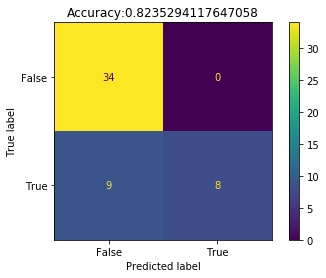

In [44]:
# Plot the confusion matrix
disp = plot_confusion_matrix(clf, X_test, list(y_test) )
conf_mat = confusion_matrix(pred, list(y_test))
acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
plt.title('Accuracy:' + str(acc))
plt.show()

# If we run the code several times, the accuracy that the model returns is in the 70-80% range

Model compiled ok
Model compiled ok
Model compiled ok
Model compiled ok


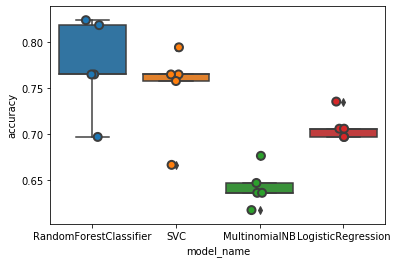

In [45]:
# Now let's look at other classifiers to select the best model for the task. 
# I went for the RandomForestClassifier (also a suitable model for this type of data), MultinomialNB, and LogisticRegression.

models = [
    RandomForestClassifier(n_estimators=600, max_depth=3, random_state=0),
    svm.SVC(kernel = 'poly'),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# cross-validation: test how good our models are on 1/5 of the data
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
# use normalised features from the dataframe as features and True/False fraud labels as labels
features = features_norm
labels = list(df_features.iloc[:,0])

# count accuracies for every model in the list
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  print ('Model compiled ok')

# create a datafrabe with cross-falidation results
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

# plot the chart for the models
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [46]:
# Accuracy numbers
cv_df.groupby('model_name').accuracy.mean()
# Our chosen model performs well, and the data isn't spread out too broadly, it's relatively stable.

model_name
LogisticRegression        0.708200
MultinomialNB             0.642781
RandomForestClassifier    0.773619
SVC                       0.749554
Name: accuracy, dtype: float64

In [47]:
# Now let's select the most important features of the model

classifier = clf

# select 3 best features by using backward feature selection.
sfs1 = SFS(classifier,k_features=3, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

sfs1 = sfs1.fit(f, l)
sfs1.subsets_

# If we fun this code several times and experiment with the # of features (k_features parameter)
# and forward and backward feature selection (forward parameter), we'll see that the features that appear frequently 
# are 3 (amount of average transaction), 4 (max transaction), and 8 (# of unique payment methods).

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished

[2020-08-24 19:29:01] Features: 8/3 -- score: 0.7738095238095238[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished

[2020-08-24 19:29:01] Features: 7/3 -- score: 0.7738095238095238[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s finished

[2020-08-24 19:29:01] Features: 6/3 -- score: 0.7738095238095238[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

{9: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8),
  'cv_scores': array([0.77380952]),
  'avg_score': 0.7738095238095238,
  'feature_names': ('0', '1', '2', '3', '4', '5', '6', '7', '8')},
 8: {'feature_idx': (0, 1, 2, 3, 4, 6, 7, 8),
  'cv_scores': array([0.77380952]),
  'avg_score': 0.7738095238095238,
  'feature_names': ('0', '1', '2', '3', '4', '6', '7', '8')},
 7: {'feature_idx': (0, 2, 3, 4, 6, 7, 8),
  'cv_scores': array([0.77380952]),
  'avg_score': 0.7738095238095238,
  'feature_names': ('0', '2', '3', '4', '6', '7', '8')},
 6: {'feature_idx': (2, 3, 4, 6, 7, 8),
  'cv_scores': array([0.77380952]),
  'avg_score': 0.7738095238095238,
  'feature_names': ('2', '3', '4', '6', '7', '8')},
 5: {'feature_idx': (2, 3, 4, 6, 8),
  'cv_scores': array([0.76785714]),
  'avg_score': 0.7678571428571429,
  'feature_names': ('2', '3', '4', '6', '8')},
 4: {'feature_idx': (3, 4, 6, 8),
  'cv_scores': array([0.7797619]),
  'avg_score': 0.7797619047619048,
  'feature_names': ('3', '4', '6', '8')},

//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


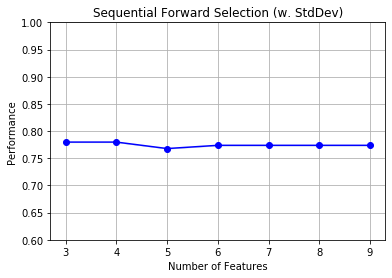

In [48]:
# Plot the chart for the model performance and the number of features it has
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
plt.ylim([0.6, 1])

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
# Out of the features created, 3 features are optimal for determining whether the user is traudulent or not.

# Potential areas of exploration and designing features are:
# looking at the payment method provider and payment method issuer,
# failed transactions with respect to the payment method;
# state of the orders.